# Rankine-Hugoniot solver

流体の保存の式は
$$
\frac{\partial F}{\partial t}+\frac{\partial G}{\partial x}=0
$$
で表されるが、定常であること・不連続であることを考慮すると

$$
[G]^2_1 = G_2 - G_1 = 0\quad\rightarrow\quad G_2=G_1
$$

が成り立つ（但し添字の1, 2は不連続面の上流・下流側の量を示す）。ここで$G$は

* mass flux
* momentum flux
* energy flux

であり、これらが不連続面の両側で保存されることを意味している。電磁流体（MHD）において、これは

$$
[\rho u]^2_1=0
$$

$$
[\rho u^2 + \frac{\gamma}{\gamma-1}P+\frac{1}{\mu_0}B^2]^2_1=0
$$

また誘導方程式と磁力線凍結（$\vec{E}+\vec{u}\times\vec{B}=0$）より

$$
[u_y B_z - u_z B_y]^2_1 = 0
$$

も成り立つ。

以上の関係式を用いると、衝撃波の上下流の流体速度をnormal Alfven velocityで規格化した

$$
A_{x,n} = \frac{u_{x,n}}{\frac{B_x}{\sqrt{\mu_0 \rho_n}}},
$$

は以下の関係式を満たす。

$$
{A_{x,1}}^2={A_{x,2}}^2\left( \frac{\gamma-1}{\gamma}\left( \frac{\gamma+1}{\gamma-1}-\tan^2\theta\right)\left({A_{x,2}}^2-1\right)^2 + \tan^2\theta\left(\frac{\gamma-1}{\gamma}{A_{x,2}}^2-1\right)\left({A_{x,2}}^2-2\right) \right)-\frac{\beta}{\cos^2\theta}\left({A_{x,2}}^2-1\right)^2
$$

$$
\frac{{A_{x,1}}^2}{{A_{x,2}}^2}=\frac{\rho_2}{\rho_1}
$$

In [1]:
import sys
import numpy as np

class MHDphase:
    def __init__(self, beta, theta, xacc=1.e-6):
        # beta and theta : upstream quantities
        # squared mf: fast MS, ms: slow MS, mi: another branch of Alfven velocity
        # normalized by the upstream normal Alfven velocity 
        self.beta = beta
        self.theta = theta
        self.mf = self.rhsol(1.0+xacc, 1.e+10)
        self.ms = self.rhsol(0.0, 1.0-xacc)
        self.mi = self.rhsol(0.0, 1.0, alf_mode=True)
        self.mcd, self.mcu = self.critical_Alfven()

    def ax1(self, ax2, gamma=5./3.):
        # determine the square of the upstream Alfven Mach number from that in the downstream
        beta = self.beta
        theta = self.theta
        deg2rad = np.pi/180.
        tanth2 = np.tan(theta*deg2rad)**2
        costh2 = np.cos(theta*deg2rad)**2

        x1 = ax2*( (gamma-1.)/gamma * ( (gamma+1.)/(gamma-1.) - tanth2 ) * \
                       (ax2-1.)**2 + tanth2*( (gamma-1.)/gamma*ax2 - 1. ) * \
                       ( ax2-2.) ) - beta/costh2*(ax2-1.)**2
        x2 = (gamma-1.)/gamma * (ax2-1.)**2/costh2 - ax2*tanth2*( (gamma-1.)/gamma*ax2 - 1. )

        return x1/x2

    def rhsol(self, x1, x2, alf_mode=False, xacc=1.e-6, iteration=1000):
        beta = self.beta
        theta = self.theta
        for j in range(iteration):
            if(alf_mode):
                x1ref = x2ref = 1.0
            else:
                x1ref = x1
                x2ref = x2
            f2 = self.ax1(x2) - x2ref
            f1 = self.ax1(x1) - x1ref
            if f1*f2 > 0:
                print('root must be bracketed in bisection')
                break
            xmid = 0.5 * (x2 + x1)
            if(alf_mode):
                xref = 1.0
            else:
                xref = xmid
            fmid = self.ax1(xmid) - xref
            if f1*fmid > 0.0:
                x1 = xmid
            else:
                x2 = xmid
            if np.absolute(fmid) < xacc:
                return xmid
        print('lack of iteration')

    def critical_Alfven(self, step = 1.e-5):
        # determine the critical Alfven Mach number
        # Ma_down > xmax: weak intermediate shock
        # Ma_down < xmax: strong intermediate shock
        # ymax: critical Alfven Mach number of upstream flow
        ymax = -1.e+10
        x = (self.ms)**2
        while x < 1.0:
            y = self.ax1(x)
            if y > ymax:
                xmax = x
                ymax = y
            x = x + step
        return xmax, ymax

    def solsearch(self, xdown, mode):
        # mode 1: fast shock 2: slow shock 3: IS
        ax2 = xdown**2
        deg2rad = np.pi/180.
        while(True):
            if mode == 1:
                if ax2 > self.mf:
                    break
            elif mode == 2:
                if self.ms < ax2 < self.mi:
                    break
            else:
                if self.mi < ax2 < 1.0:
                    break
            print('value is not suitable for RH')
            sys.exit()

        ax1 = self.ax1(ax2)
        r = ax1/ax2
        thetad = np.rad2deg( np.arctan( (ax1-1.)/(ax2-1.)*np.tan(self.theta*deg2rad) ) )
        bd = np.cos(self.theta*deg2rad)/np.cos(thetad*deg2rad)
        bt = bd * np.sin(thetad*deg2rad)
        uin = (1.-1./r)*np.sqrt(ax1)*np.cos(self.theta*deg2rad)
        vshock = np.sqrt(ax2/r)*np.cos(self.theta*deg2rad)
        print('compressional ratio    : ' + str(r) )
        print('downstream field angle : ' + str(thetad) )
        print('downstream field mag.  : ' + str(bd) )
        print('injection velocity     : ' + str(uin) )
        print('shock velocity         : ' + str(vshock) )


In [2]:
va = MHDphase(0.1, 60.)

Text(0,0.5,'${A_{x1}}^2$')

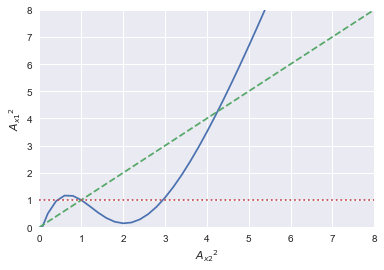

In [9]:
ax2 = np.arange(100)*0.2
ax1 = va.ax1(ax2)
%matplotlib inline

plt.plot(ax2, ax1)
plt.plot(ax2, ax2, linestyle='dashed')
plt.plot([0,8],[1,1],linestyle='dotted')
plt.xlim(0,8)
plt.ylim(0,8)
plt.xlabel('${A_{x2}}^2$')
plt.ylabel('${A_{x1}}^2$')

上の図は衝撃波上流で$\beta=0.1, \theta=60^\circ$の場合の上下流のnormal Alfven Mach numberの関係を示している。$({A_{x2}}^2 = {A{x1}}^2)$との交点が小さい方からslow mode, intermediate mode, fast modeの解となり、